# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import *
from dsp_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "4PAM"

In [2]:
seed_ = np.random.randint(500000)
print(seed_)
np.random.seed(seed_)

89376


# Source Generation and Mixing Scenario

In [3]:
N = 100000
NumberofSources = 3
NumberofMixtures = 4
S = 2 * (np.random.randint(0,4,(NumberofSources, N))) - 3
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
print("Condition Number of Mixing Matrix is {}".format(np.linalg.cond(A)))
SNRlevel = 30
X, NoisePart = addWGN(X, SNRlevel, return_noise = True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

Condition Number of Mixing Matrix is 4.651904650439034
The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.00278794064231


# Visualize Generated Sources and Mixtures

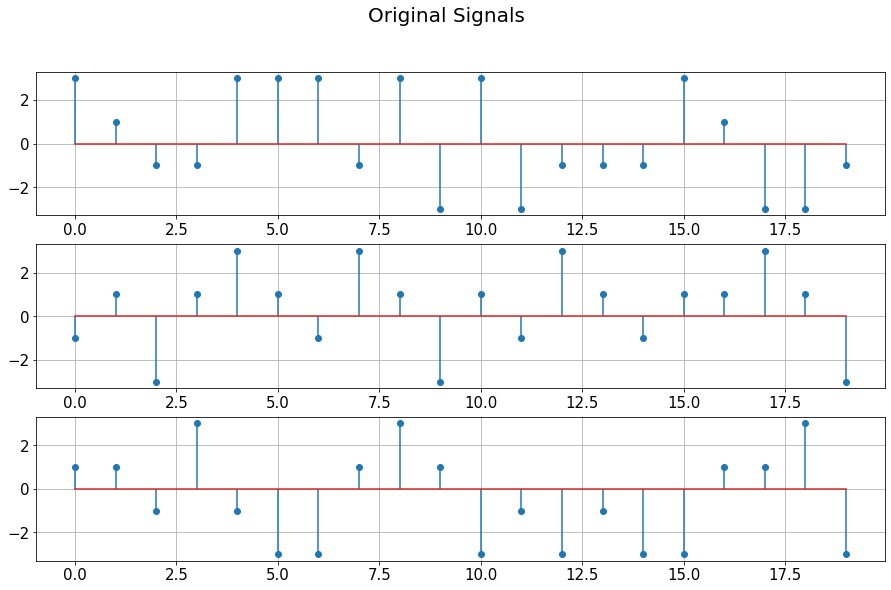

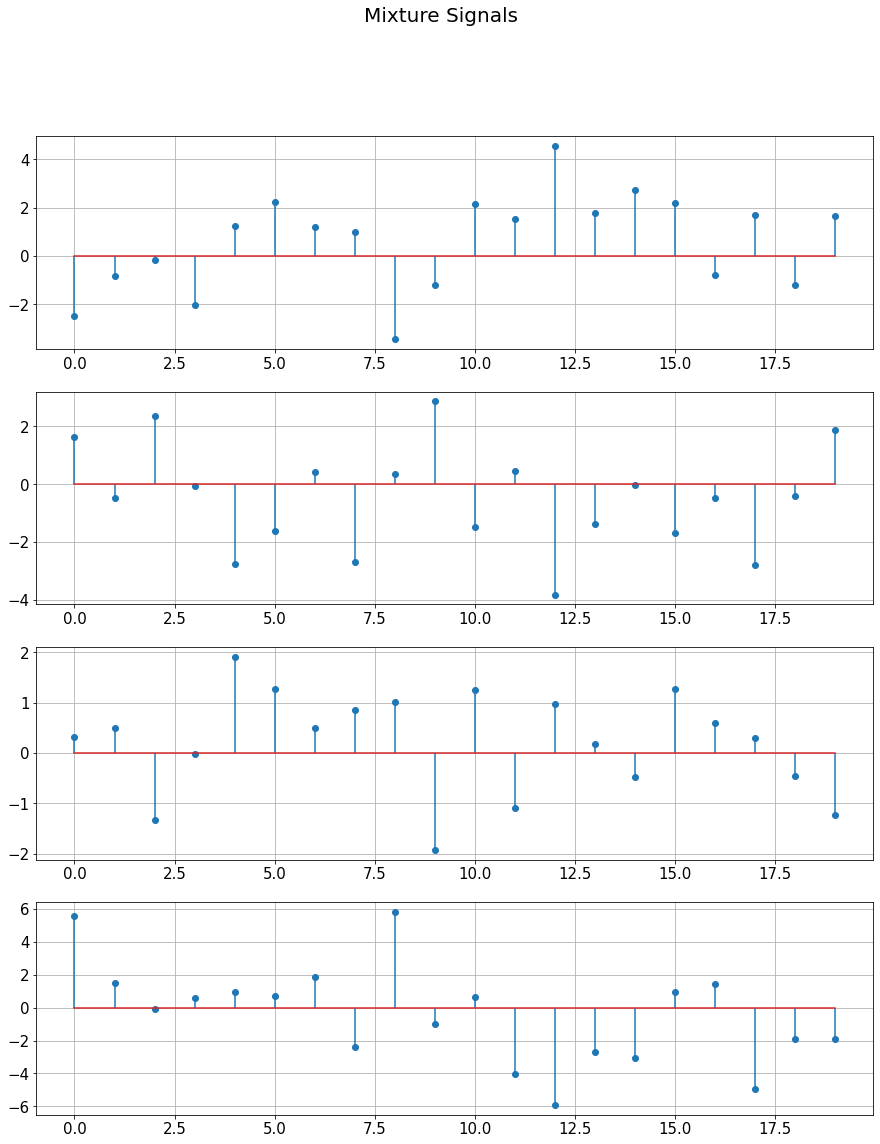

In [4]:
substem_1D_signals(
    S[:, 0:20], title="Original Signals", figsize=(15.2, 9)
)
substem_1D_signals(
    X[:, 0:20], title="Mixture Signals", figsize=(15, 18)
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
lambday = 1 - 1e-1 / 10
lambdae = 1 - 1e-1 / 10
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1000 * np.eye(s_dim)

debug_iteration_point = 25000
model = OnlineCorInfoMax(
    s_dim=s_dim,
    x_dim=x_dim,
    muW=30 * 1e-3,
    lambday=lambday,
    lambdae=lambdae,
    By=By,
    Be=Be,
    neural_OUTPUT_COMP_TOL=1e-6,
    set_ground_truth=True,
    S=S,
    A=A,
)

# Run CorInfoMax Algorithm on Mixture Signals

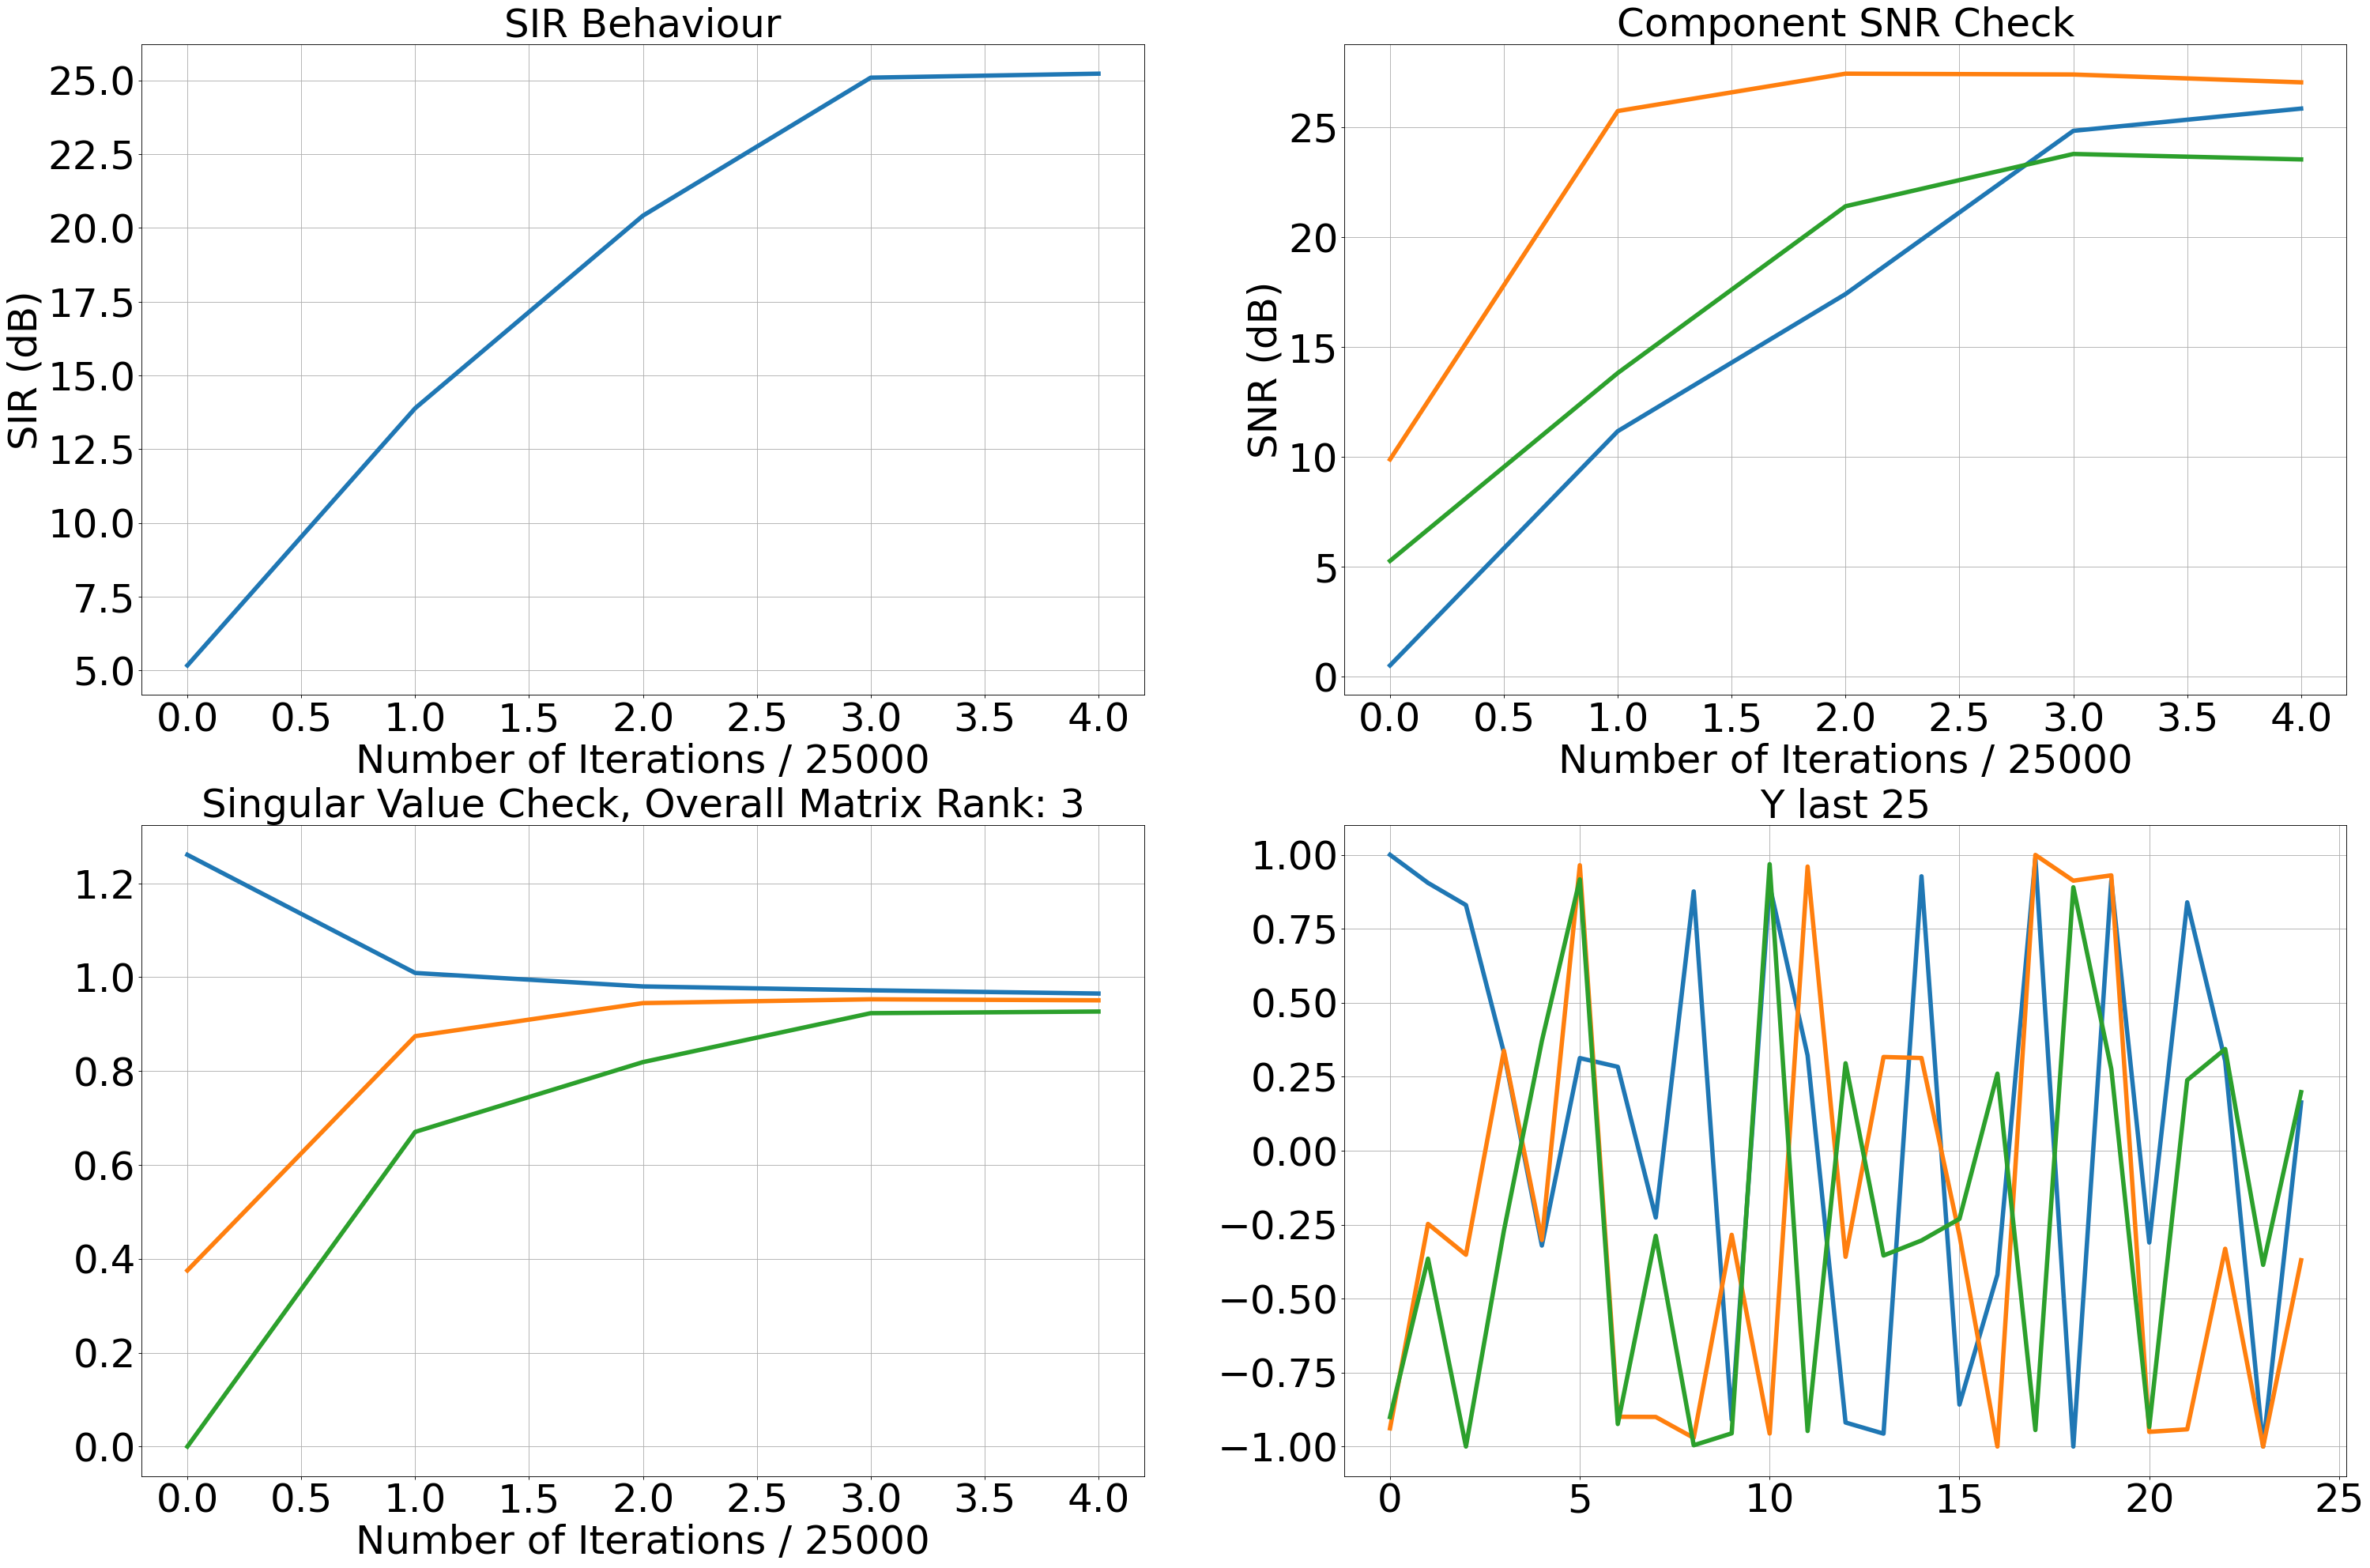

100%|██████████| 100000/100000 [00:29<00:00, 3388.59it/s]


Algorithm took 29.586421 sec.


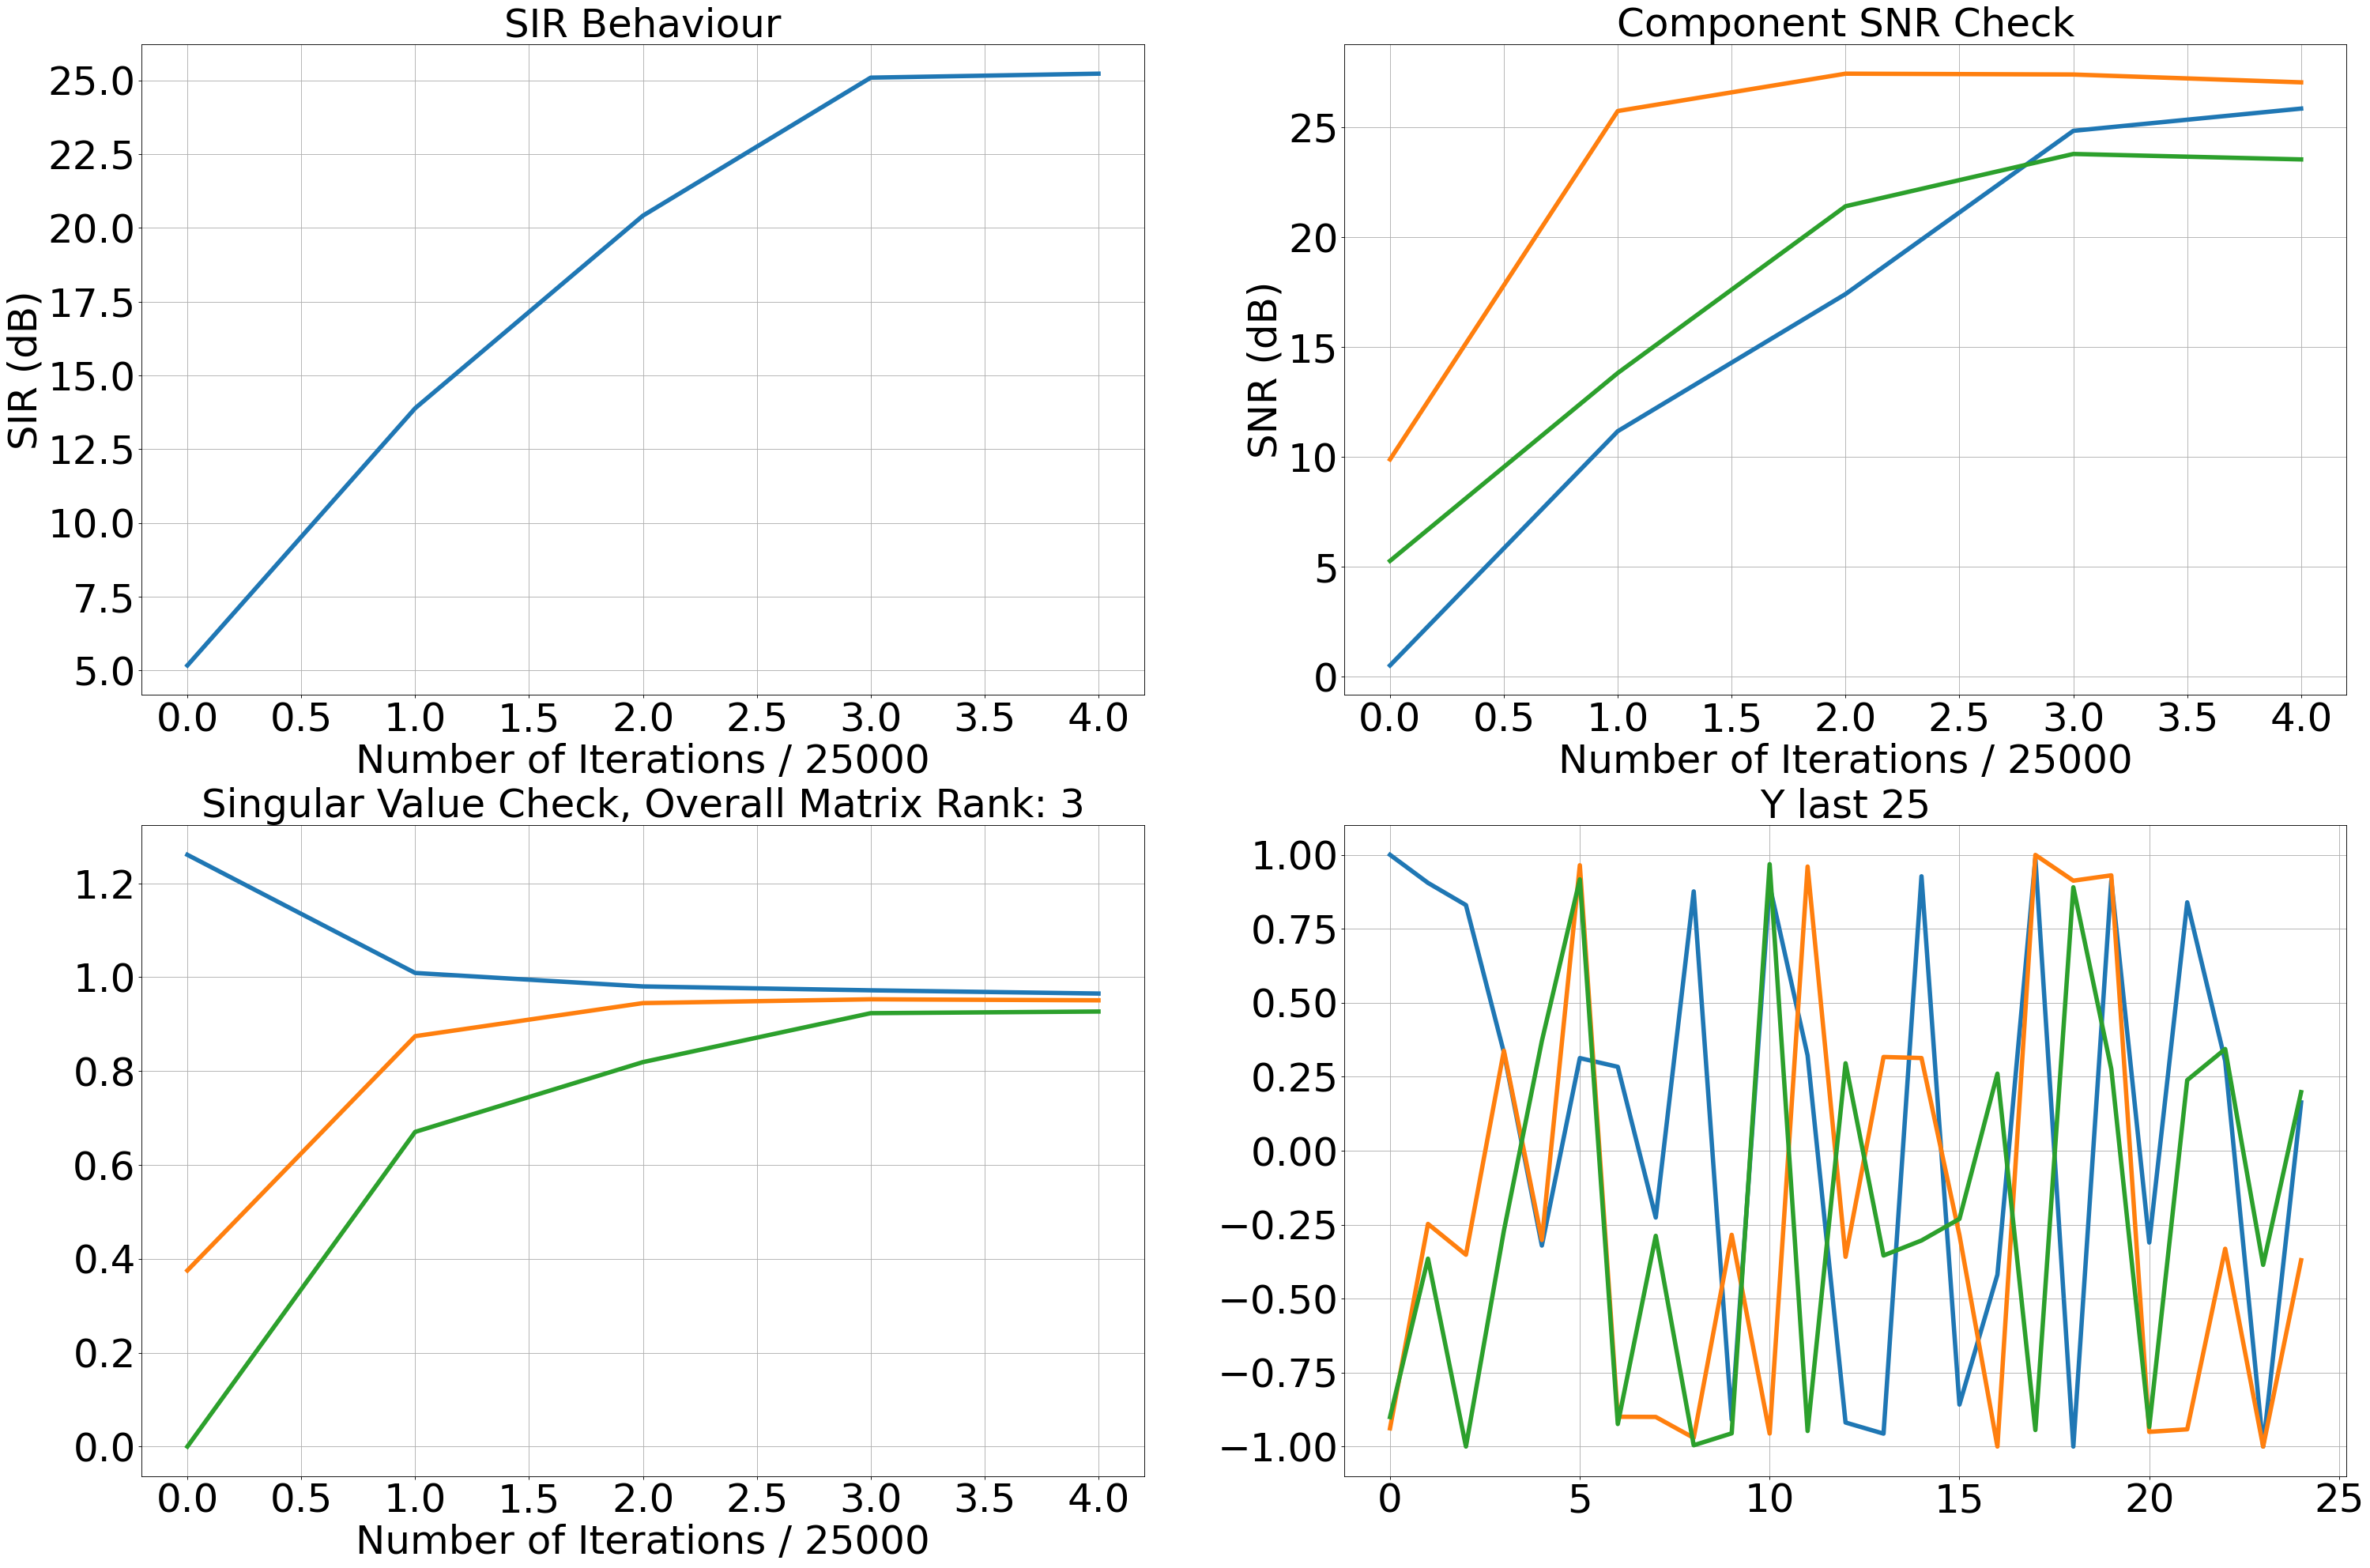

In [6]:
with Timer() as t:
    model.fit_batch_antisparse(
        X=X/3,
        n_epochs=1,
        neural_dynamic_iterations=500,
        plot_in_jupyter=True,
        neural_lr_start=0.9,
        neural_lr_stop=0.001,
        debug_iteration_point=debug_iteration_point,
        shuffle=True,
    )
print("Algorithm took %f sec." % (t.interval))

# Visualize SINR Convergence 

Final SINR: 25.222388171129097


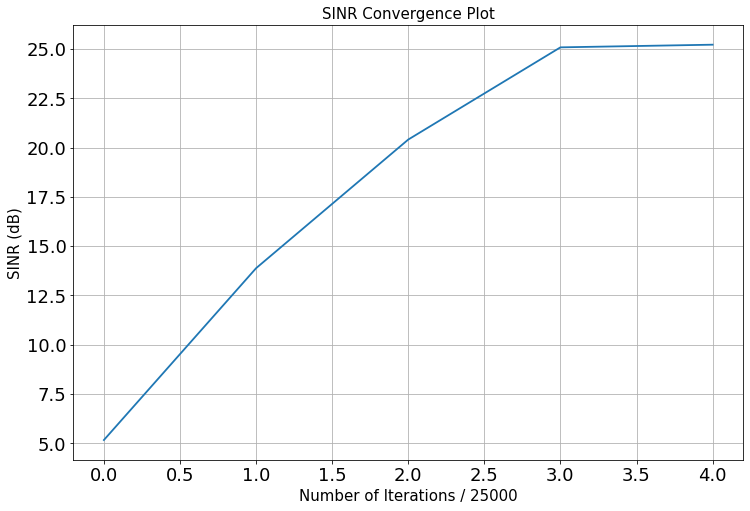

In [7]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    model.SIR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

print("Final SINR: {}".format(np.array(model.SIR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = model.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [25.85855806 27.05382805 23.54400884]

Overall SINR : 25.222388171129097


# Vizualize Extracted Signals Compared to Original Sources

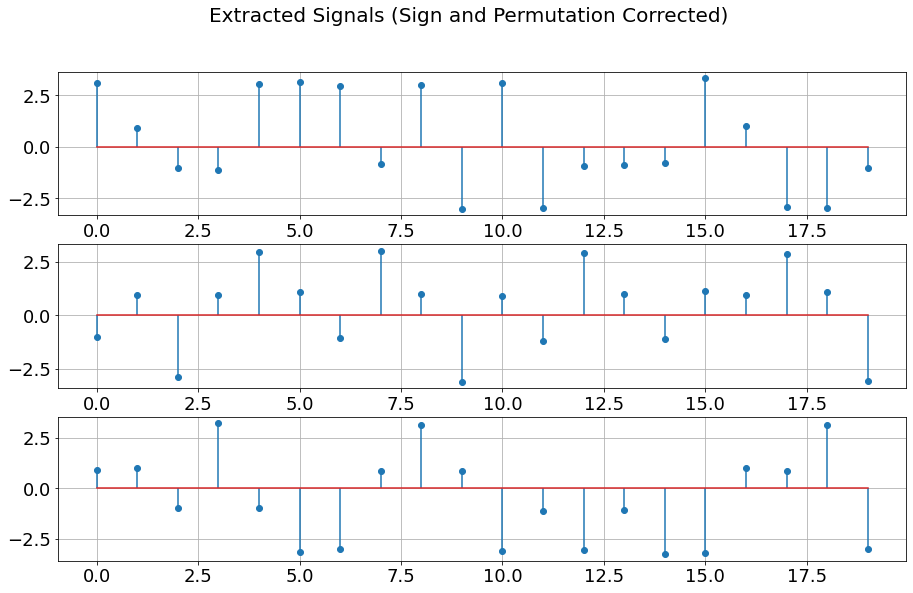

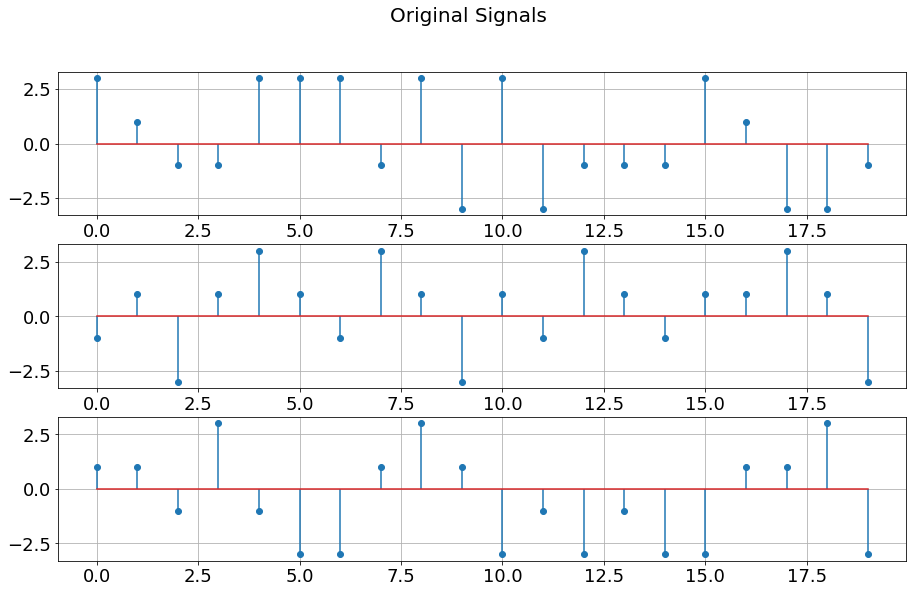

In [9]:
substem_1D_signals(
    Y_[:, 0:20],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
)
substem_1D_signals(
    S[:, 0:20], title="Original Signals", figsize=(15.2, 9)
)

# Measure Symbol Error Rate

In [10]:
Wf = model.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
Y_pred = map_estimates_to_symbols(Y_, np.array([-3, -1, 1, 3]))
SER(S, Y_pred)

0.0